In [10]:
% setup environment
% clear data and number format
clear; format short e
% set path to equilibrium solver
txt=pwd; n=length(txt); rootpath=txt;
n=strfind(rootpath,"USERS"); rootpath=txt(1:n-2);
PHREEQCpath=[rootpath,'/runPHREEQC'];
addpath(PHREEQCpath);
JEQUILIBpath=[rootpath,'/JEQUILIB'];
addpath(JEQUILIBpath);
% turn off warnings
warning off
%graphics_toolkit ("notebook"); 
graphics_toolkit ("plotly"); 
%graphics_toolkit("gnuplot")
% delete phreeqcrunfile
%system("rm porttest.txt");

In [11]:
database=['llnl.dat'];

from phreeqc support site

https://phreeqcusers.org/index.php?topic=2260.0

This doesnt; really work.  the idea is to calculate the DIC and compare to equilib DIC for that pH and atmopheric CO2.  the distance away will determine the rate.  faster away should be faster.  as the values approach the rate would be zero.  Same as is done for mineral ppte/dissolution.

I think it doesn't work because of some autmoated way C is handeled.  related to alklinity?  I don't know.  but when this gets run if you look at the out put it says C is negative ... but how is that possible since the program is suppoed to step up C according to the rate expression and C is specified as a positive number.

if you make M0 larger you'd expect it to degas but that doesn't happen for some reason.  it actually just goes to flat value.  only the M0 of 2e-5 and rate constant 2e-6 give reasonable values.  very frustrating.

I could code this approach using ODE I think.



In [12]:
fromwebtext=[...
{'RATES\n'}
{'CO2_dissolution\n'}
{'-start\n'}
{'20 k = parm(1)\n'}
{'30 H=ACT("H+")\n'}
{'70 CT = ACT("CO2")+ACT("CO3-2")+ACT("HCO3-")\n'}
{'80 H2CO3mod =(10^-3.5)*(10^-1.5)\n '}
{'90 HCO3mod = (H2CO3mod*(10^-6.3))/H\n'}
{'100 CO3mod = (HCO3mod*(10^-10.3))/H\n'}
{'110 CTmod=H2CO3mod+HCO3mod+CO3mod\n'}
{'120 SI_CO2=(CTmod/CT)\n'}
{'130 rate = PARM(1) *M* ((SI_CO2)-1) \n'}
{'140 moles = rate*time \n'}
{'150 SAVE moles\n'}
{'-end\n'}
{'SOLUTION 1\n'}
{'       pe      13.75\n'}
{'       pH      7 \n'}
{'       temp    25\n'}
{'-units mol/kgw\n'}
{'KINETICS\n'}
{'CO2_dissolution\n'}
{'-formula C 1\n'}
{'-m0 2e-5\n'}
{'-parm 2e-6 # rate constant \n'}
{'-time 0 500 1000 5000 10000 50000 100000 500000 1000000\n'}
];
[nolines,length]=size(fromwebtext);

In [13]:
selectboxtext=[...
{' SELECTED_OUTPUT\n'}
{' -file CO2out.txt\n'}
{' -selected_out true\n'}
{' -user_punch true\n'}
{' -high_precision true\n'}
{' -reset false\n'}
{' -simulation false\n'}
{' -state false\n'}
{' -distance false\n'}
{' -time false\n'}
{' -step false\n'}
{' -ph false\n'}
{' -pe false\n'}
{' -reaction false\n'}
{' -temperature false\n'}
{' -alkalinity false\n'}
{' -ionic_strength false\n'}
{' -water false\n'}
{' -charge_balance false\n'}
{' -percent_error false\n'}
];
[nolinesSEL,length]=size(selectboxtext);

In [14]:
punchboxtext=[...
{'USER_PUNCH\n'}
{'        -headings seconds  pH  logHCO3 logCO3 logH2CO3 \n'}
{'  10 PUNCH SIM_TIME, -LA("H+"), LA("HCO3-"), LA("CO3-2"), LA("CO2")\n'}
];
[nolinesPUNCH,length]=size(punchboxtext);

In [15]:
fileID=fopen('CO2test.txt','w');

fprintf(fileID,'TITLE TEST CO2 DISSOLUTION\n');

for i=1:nolines
    line=cell2mat(fromwebtext(i,:));
    fprintf(fileID,line)
end

fprintf(fileID,'\n');
for i=1:nolinesSEL
    line=cell2mat(selectboxtext(i,:));
    fprintf(fileID,line)
end

fprintf(fileID,'\n');
for i=1:nolinesPUNCH
    line=cell2mat(punchboxtext(i,:));
    fprintf(fileID,line)
end

fclose(fileID);

In [16]:
str=['system("phreeqc CO2test.txt out.txt ', database,'");'];
eval(str); % output to the screen
%evalc(str); % so no screen output
fid = fopen('CO2out.txt','rt');
hdr = strtrim(regexp(fgetl(fid),'\t','split'));
hdr=hdr(1:5)';
mat = cell2mat(textscan(fid,repmat('%f',1,numel(hdr))));
[nsize,msize]=size(mat);
time=mat(2:nsize,1); pHphreeqc=mat(2:nsize,2); HCO3=10.^(mat(2:nsize,3)); CO3=10.^(mat(2:nsize,4)); H2CO3=10.^(mat(2:nsize,5));
CT=HCO3+H2CO3+CO3

CT,1
1,3.06988e-100
2,9.50222e-07
3,1.26479e-06
4,2.43591e-06
5,3.20327e-06
6,5.77035e-06
7,7.19134e-06
8,1.05636e-05
9,1.16229e-05


pHequil = 5.6500e+00


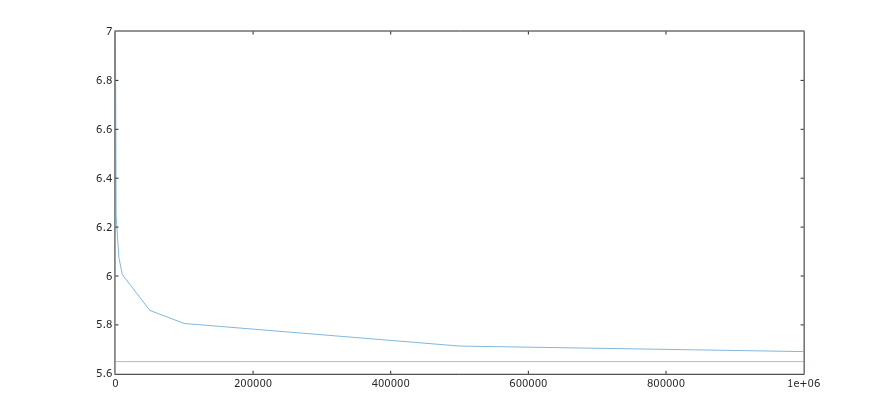

In [17]:
pHequil=-log10(sqrt(10^-3.5*10^-1.5*10^-6.3))

plot(time,pHphreeqc,time,pHequil*ones(size(time)))

CTmod,1
1,6.01438e-05
2,2.05366e-05
3,1.88399e-05
4,1.5961e-05
5,1.50772e-05
6,1.36255e-05
7,1.32048e-05
8,1.25913e-05
9,1.24594e-05


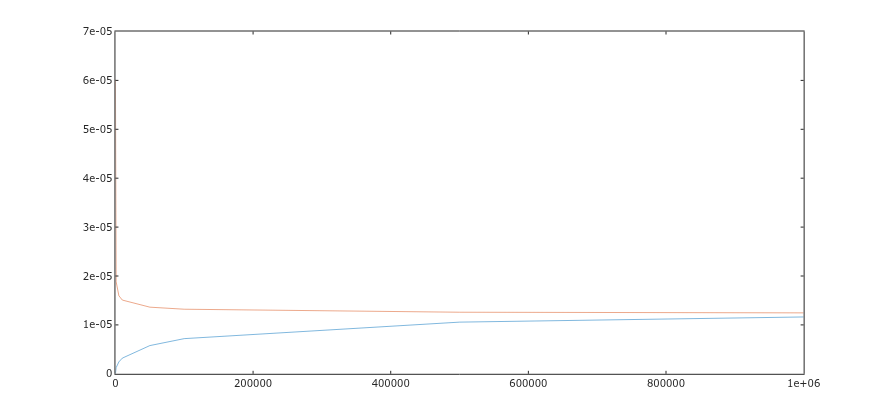

SI_CO2,1
1,1.95916e+95
2,21.6124
3,14.8957
4,6.55239
5,4.70682
6,2.3613
7,1.83621
8,1.19195
9,1.07197


rate,1
1,1.95916e+95
2,20.6124
3,13.8957
4,5.55239
5,3.70682
6,1.3613
7,0.836209
8,0.191949
9,0.0719693


In [18]:
H=10.^-pHphreeqc;
H2CO3mod =(10^-3.5)*(10^-1.5);
HCO3mod = (H2CO3mod*(10^-6.3))./H;
CO3mod = (HCO3mod*(10^-10.3))./H;
CTmod=H2CO3mod+HCO3mod+CO3mod

plot(time,CT,time,CTmod)

SI_CO2=CTmod./CT
rate = (SI_CO2)-1

